<a href="https://colab.research.google.com/github/Steve-YJ/Exp-Standalone-DeepLearning/blob/master/%5BPractice%5D_Cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lec3. Practice
# CIFAR-10 Classifier: Hyperparameter Tunning!!
* Training with PyTorch
* 20.09.04.Fri. pm 9:00
* Review >>> 20.09.07.mon. pm 6:25
* Again >>> 20.09.22.Ture. pm 4:00
<br><br>
* Reference: https://github.com/heartcored98/Standalone-DeepLearning/blob/master/Lec3/Lab4_write_pretty_DL_code.ipynb


> <code>학습 Flow</code> -20.09.16.wed-<br>
> Import Library<br> 
> Data Preparation<br>
> Model Architecture<br>
> Define Exp<br>
> Experiment!<br>


# Import Library

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import numpy as np

## Data Preparation

In [2]:
# data preparation?
transform = transforms.Compose(
    [transforms.ToTensor(),  # ToTensor를 해주면 0에서 1사이의 값으로 바꿔줌
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]  # 모든 픽셀의 Red값에서 0.5를 빼겠다
)  # Compose Several transforms together

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                        download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000]) # Randomly split a dataset into non-overlapping new datasets of given lengths. Optionally fix the generator for reproducible results, e.g.:
                                                                           # e.g) random_split(range(10), [3, 7], generator=torch.Generator().manual_seed(42))
testset = torchvision.datasets.CIFAR10(root='./data', train=False, 
                                       download=True, transform=transform)

# Make train, val, test loader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, 
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=4,
                                        shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Inspect Dataset

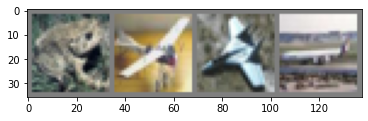

 frog plane plane plane
<class 'torch.Tensor'> torch.Size([4, 3, 32, 32])
<class 'torch.Tensor'> torch.Size([4]) tensor([6, 0, 0, 0])


"\nclasses = ('plane', 'car', 'bird', 'cat',\n           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')\n"

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

print(type(images), images.shape)
print(type(labels), labels.shape, labels)  # 각각의 클래스

'''
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
'''

Q. torch.Size([4, 3, 32, 32])를 해석할 수 있는가??<br>
A. 4개의 데이터 3개의 채널 32x32

# Model Architecture

In [15]:
import torch.nn as nn
import torch.nn.functional as F


class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, hid_dim, n_layer, act):
        super(MLP, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.hid_dim = hid_dim
        self.n_layer = n_layer
        self.act = act
        
        self.fc = nn.Linear(self.in_dim, self.hid_dim)
        self.linears = nn.ModuleList()

        for i in range(self.n_layer-1):
            self.linears.append(nn.Linear(self.hid_dim, self.hid_dim))        
        self.fc2 = nn.Linear(self.hid_dim, self.out_dim)

        # Define Activation Function
        if self.act == 'relu':
            self.act = nn.ReLU() 
        else:
            raise RuntimeError

    def forward(self, x):
        x = self.act(self.fc(x))
        for fc in self.linears:
            x = self.act(fc(x))
        x = self.fc2(x)  # 마지막 레이어는 activation function 값을 통과하지 않는다
        return x


net = MLP(3072, 10, 100, 4, 'relu')
print(net)

MLP(
  (fc): Linear(in_features=3072, out_features=100, bias=True)
  (linears): ModuleList(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=100, bias=True)
  )
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (act): ReLU()
)


# Optimizer / Loss Function

In [37]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=0.001)

print(criterion)
print(optimizer)

CrossEntropyLoss()
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)


# Experiment

In [84]:
def experiment(args):
    device = "cuda:0" if torch.cuda.is_available() else "cpu"

    # Define Model
    net = MLP(args.in_dim, args.out_dim, args.hid_dim, args.n_layer, args.act)
    net.to(device)

    # Define Loss Function & Optimization
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=args.lr, momentum=args.mm)

    for epoch in range(args.epoch):  # loop over the dataset multiple times
        # ===== Train ===== #
        train_loss = 0
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            # print(inputs.shape, labels.shape)
            inputs = inputs.view(-1, 3*32*32)
            inputs = inputs.to(device)
            labels = labels.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # print statistics
            running_loss += loss.item()
            train_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0
            
        # ===== Valication ===== # 
        correct = 0
        total = 0

        val_loss = 0
        with torch.no_grad():
            for data in valloader:
                images, labels = data
                images = images.view(-1, 3*32*32)
                images = images.to(device)
                labels = labels.to(device)
                outputs = net(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            val_loss = val_loss / len(valloader)
            # print(val_loss)
            val_acc = 100 * correct / total
            
        print('Epoch {}, Train Loss: {}, Val Loss: {}, Val Acc: {}'.format(epoch, train_loss, val_loss, val_acc))

    # ===== Evaluation ===== #
    correct = 0
    total = 0

    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.view(-1, 3*32*32)
            images = images.to(device)
            labels = labels.to(device)

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        test_acc = 100 * correct / total

    return train_loss, val_loss, val_acc, test_acc

In [ ]:
import argparse

seed = 123
parser = argparse.ArgumentParser()
args = parser.parse_args("")

# Hypter Parameter Tuning
args.n_layer = 5
args.in_dim = 3072
args.out_dim = 10
args.hid_dim = 100
args.act = 'relu'

args.lr = 0.001
args.mm = 0.9
args.epoch = 100

list_var1 = [4, 5, 6]
list_var2 = [50, 100, 150]

for var1 in list_var1:
    for var2 in list_var2:
        args.n_layer = var1
        args.hid_dim = var2
        result = experiment(args)
        print(result)

[1,  2000] loss: 2.183
[1,  4000] loss: 1.909
[1,  6000] loss: 1.800
[1,  8000] loss: 1.731
[1, 10000] loss: 1.690
Epoch 0, Train Loss: 18626.06376066804, Val Loss: 1.6451382421731948, Val Acc: 41.05
[2,  2000] loss: 1.636
[2,  4000] loss: 1.619
[2,  6000] loss: 1.597
[2,  8000] loss: 1.576
[2, 10000] loss: 1.563
Epoch 1, Train Loss: 15981.995784908533, Val Loss: 1.5676900147795678, Val Acc: 43.63
[3,  2000] loss: 1.503
[3,  4000] loss: 1.498
[3,  6000] loss: 1.501
[3,  8000] loss: 1.498
[3, 10000] loss: 1.490
Epoch 2, Train Loss: 14979.930822059512, Val Loss: 1.4947389998912812, Val Acc: 47.07


## Appendix
* <code>seed</code>

In [59]:
seed = 123
np.random.seed(seed)
a = np.random.randn()
a

-1.0856306033005612

hyperparameter 튜닝을 할 떄, hyperparameter 값의 변화에 따라 값이 변하는지 또는 학습시 랜덤하게 값이 변해서 결과 값이 변하는지 확인할 수 있어야 한다

###  코드를 짜는 두 가지 방식
* Epoch내에 Train, Validation을 구현하고 Evaluation을 기록한다

### Appendix
* <code>with torch.no_grad()</code>
albanD
1 
Jun '18
Hi,

* These two have different goals:

    * model.eval() will notify all your layers that you are in eval mode, that way, batchnorm or dropout layers will work in eval mode instead of training mode.
    * torch.no_grad() impacts the autograd engine and deactivate it. It will reduce memory usage and speed up computations but you won’t be able to backprop (which you don’t want in an eval script).